# Parallelizing Neural Network Training with Tensorflow

## First Steps with Tensorflow

Let's tart by exploring tensorflow's low level API.

In [12]:
import tensorflow as tf
import numpy as np

In [13]:
# create a graph
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32,
                      shape=(None),
                      name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    
    z = w*x + b
    
    init = tf.global_variables_initializer()
    
# create session and pass in graph g
with tf.Session(graph=g) as sess:
    # initalize w and b
    sess.run(init)
    # evaluate z
    for t in [1.0, 0.6, -1.8]:
        print ('x = %4.1f --> z = %4.1f' % (t, sess.run(z, feed_dict={x:t})))

x =  1.0 --> z =  2.7
x =  0.6 --> z =  1.9
x = -1.8 --> z = -2.9


## Working with Array Structures

In [16]:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None, 2, 3),
                       name='input_x')
    
    x2 = tf.reshape(x, shape=(-1, 6),
                   name='x2')
    
    
    ## calculate the sum of each column
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    ## calcualte the mean of each column
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')
    
with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3,2,3)
    
    print ('input shape: ', x_array.shape)
    print ('Reshaped\n', sess.run(x2, feed_dict={x:x_array}))
    print ('Column Sums \n', sess.run(xsum, feed_dict={x:x_array}))
    print ('Column Means \n', sess.run(xmean, feed_dict={x:x_array}))

input shape:  (3, 2, 3)
Reshaped
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column Sums 
 [18. 21. 24. 27. 30. 33.]
Column Means 
 [ 6.  7.  8.  9. 10. 11.]


## Developing a Simple Model with the Low-Level Tensorflow API

Let's implement an OLS regression using Tensorflow.

In [18]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                   2.0, 5.0, 6.3,
                   6.6, 7.4, 8.0,
                   9.0])

# create a linear regression using tensorflow
class TfLinReg(object):
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        ## build the model
        with self.g.as_default():
            ## set graph level random seed
            tf.set_random_seed(random_seed)
            
            self.build()
            ## create initializer
            self.init_op = tf.global_variables_initializer()
            
    def build(self):
        ## define placeholders for inputs
        self.X = tf.placeholder(dtype=tf.float32,
                               shape=(None, self.x_dim),
                               name='x_input')
        self.y = tf.placeholder(dtype=tf.float32,
                               shape=(None),
                               name='y_input')
        
        ## define weight matrix and bias vector
        w = tf.Variable(tf.zeros(shape=(1)),
                       name='weight')
        b = tf.Variable(tf.zeros(shape=(1)),
                       name='bias')
        
        self.z_net = tf.squeeze(w*self.X + b,
                               name='z_net')
        
        sqr_errors = tf.square(self.y - self.z_net,
                              name='sqr_errors')
        
        
        self.mean_cost = tf.reduce_mean(sqr_errors,
                                       name='mean_cost')
        
        optimizer = tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate,
                    name='GradientDescent')
        
        self.optimizer = optimizer.minimize(self.mean_cost)
        
# instantiate model
lrmodel = TfLinReg(x_dim=X_train.shape[1])        

Instructions for updating:
Use tf.cast instead.


In [19]:
# defining a separate function to train our OLS model
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    ## initialize all variables: W and b
    sess.run(model.init_op)
    
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost],
                          feed_dict={model.X:X_train,
                                    model.y:y_train})
        training_costs.append(cost)
    
    return training_costs

sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

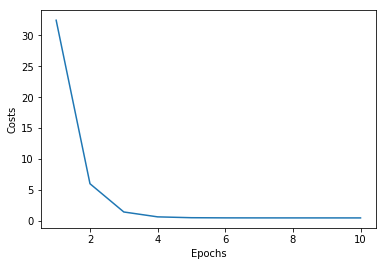

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(training_costs)+1), training_costs)
plt.xlabel('Epochs')
plt.ylabel('Costs')
plt.show()

## Developing a Multilayer Neural Network with Keras

In [26]:
# loading data
import os
import numpy as np
import struct

def load_mnist(path, kind='train'):
    """
    Load MNIST data from 'path'
    """
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                lbpath.read(8))
        labels = np.fromfile(lbpath,
                            dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                              imgpath.read(16))
        images = np.fromfile(imgpath,
                            dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - 0.5) * 2
    
    return images, labels

X_train, y_train = load_mnist('', kind='train')
X_test, y_test = load_mnist('', kind='t10k')

## mean centering and normalization
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val

del X_train, X_test

In [31]:
import tensorflow as tf
import tensorflow.keras as keras

tf.set_random_seed(123)

In [32]:
y_train_onehot = keras.utils.to_categorical(y_train)

In [34]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units=50,
        input_dim=X_train_centered.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(
    keras.layers.Dense(
        units=50,
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(
    keras.layers.Dense(
        units=y_train_onehot.shape[1],
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='softmax'))

sgd_optimizer = keras.optimizers.SGD(
    lr=0.001, decay=1e-7, momentum=0.9)

model.compile(optimizer=sgd_optimizer,
             loss='categorical_crossentropy')

In [35]:
history = model.fit(X_train_centered,
                   y_train_onehot,
                   batch_size=64,
                   epochs=50,
                   verbose=1,
                   validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 41us/sample - loss: 0.7420 - val_loss: 0.3742
Epoch 2/50
54000/54000 [==============================] - 1s 25us/sample - loss: 0.3776 - val_loss: 0.2794
Epoch 3/50
54000/54000 [==============================] - 2s 28us/sample - loss: 0.3105 - val_loss: 0.2403
Epoch 4/50
54000/54000 [==============================] - 1s 25us/sample - loss: 0.2734 - val_loss: 0.2159
Epoch 5/50
54000/54000 [==============================] - 1s 27us/sample - loss: 0.2477 - val_loss: 0.1985 
Epoch 6/50
54000/54000 [==============================] - 1s 26us/sample - loss: 0.2275 - val_loss: 0.1845
Epoch 7/50
54000/54000 [==============================] - 1s 27us/sample - loss: 0.2112 - val_loss: 0.1721s - l - ETA: 0s - loss
Epoch 8/50
54000/54000 [==============================] - 1s 27us/sample - loss: 0.1975 - val_loss: 0.1640
Epoch 9/50
54000/54000 [==============================] - 2s 31us/sample

In [36]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
correct_preds = np.sum(y_train_pred == y_train, axis=0)
print ('Training Accuracy:', correct_preds / y_train.shape[0])

Training Accuracy: 0.9884


In [37]:
y_test_pred = model.predict_classes(X_test_centered, verbose=0)
correct_preds = np.sum(y_test_pred == y_test, axis=0)
print ('Testing Accuracy:', correct_preds / y_test.shape[0])

Testing Accuracy: 0.964
